[![Colab][open-in-colab]][link]

[open-in-colab]: https://img.shields.io/badge/open%20in%20Colab-F9AB00?style=for-the-badge&logo=googlecolab&color=525252
[link]: https://colab.research.google.com/drive/11g3nrUl_HXUBqoe7CS3scbHQeVL_2ekA

Let's try to help FOX with their content. As you know, the Simpsons series has been on TV for more than 25 years and a lot of footage has accumulated over that time. The characters have changed along with changing graphic technology, and Homer Simpson 2018 doesn't look much like Homer Simpson 1989. And we need to classify the characters living in Springfield. I think there is no point in introducing each of them individually.





### Setting up

In [1]:
# we need pillow version 5.3.0
# uninstall the old version and install the new version
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

Found existing installation: Pillow 5.3.0
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Pillow-5.3.0-cp38-cp38-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.10 requires pillow>6.0.0, but you have pillow 5.3.0 which is incompatible.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.
5.3.0


In [2]:
!pip install -U torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
from tqdm.autonotebook import tqdm, trange
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import pickle
import time

import numpy as np
import pandas as pd
from skimage import io

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from multiprocessing.pool import ThreadPool

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


import torchvision
from torchvision import datasets, models, transforms


from matplotlib import colors, pyplot as plt
%matplotlib inline

# we'll ignore the warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
!nvidia-smi

<ipython-input-3-481cf0797bb9>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.8/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


CUDA is available!  Training on GPU ...
Mon Feb  6 09:13:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                

In [4]:
!pip install wandb
!wandb login
import wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.9/178.9 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=21b7b176e1efedab42ccefbc8f8cd4a225254cb2c7019514f44dbca527d80b6e
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: p

In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [7]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

In [8]:
train_val_files = list(TRAIN_DIR.rglob('*.jpg'))
test_files = list(TEST_DIR.rglob('*.jpg'))
print(len(train_val_files)) #=> 20933
print(len(test_files)) #=> 991

20933
991


In our test set, there will be 990 images for which you will need to predict a class.

In [9]:
# different dataset modes 
DATA_MODES = ['train', 'val', 'test']
# all images will be scaled to 224x224 px
RESCALE_SIZE = 224
# work on the GPU
if train_on_gpu:
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Below we use a wrapper over the dataset to make it easy to work with.

ToTensor converts PIL Image with parameters in range [0, 255] (as all pixels) into FloatTensor of size (C x H x W) [0,1] , then scaling:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br> constants - averages and dispersions per channel based on ImageNet


It's also worth noting that we override the __getitem__ method for convenience with this data structure.
 We also use LabelEncoder to convert string class labels to id and vice versa. The dataset description says that the pictures are different sizes, because they were taken directly from the video, so we should reduce them to the same size (the _prepare_sample method does this) 

In [10]:
class SimpsonsDataset(Dataset):
    """
    Dataset with pictures, which loads them from folders 
    in parallel scaling and turning them into torch tensors
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # to convert images into PyTorch tensors and normalise the input
        # transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        # ])
        # transform_tr = transform
        # transform_val = transform
        transform_val = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(244),
            transforms.CenterCrop(244),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        transform_tr = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomResizedCrop(244),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        x = self.load_sample(self.files[index])
        # x = self._prepare_sample(x)
        x = np.array(x, dtype='float32')  / 255
        if self.mode == 'train':
            x = transform_tr(x)
        else:
            x = transform_val(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [12]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [13]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [14]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Let's take a look at our heroes in the dataset.

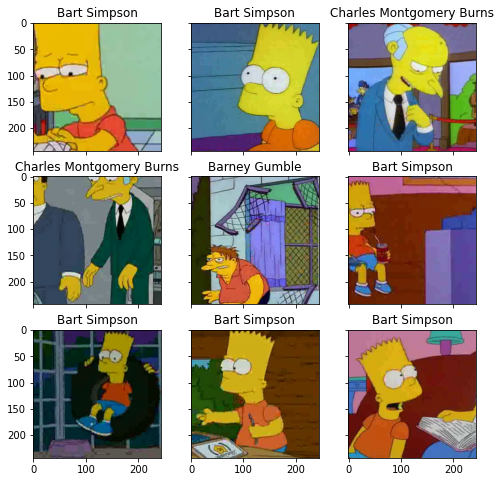

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Write a training function for the model to visualise the process in more detail

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader, leave=False, desc="Train iter"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(val_loader, leave=False, desc="Eval iter"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [19]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [20]:
n_classes = len(np.unique(train_val_labels))
print("We will classify: {}".format(n_classes))

We will classify: 42


### Add extra functions to make our work a little easier

In [21]:
def submission_to_kaggle(model, filename):
    test_dataset = SimpsonsDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
    probs = predict(model, test_loader)
    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    test_filenames = [path.name for path in test_dataset.files]

    my_submit = pd.read_csv('./sample_submission.csv') #"gdrive/MyDrive/simpsons/data/labels.csv")
    my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
    my_submit = my_submit.rename(columns={'Image_id': 'Id'})
    my_submit.head()

    my_submit.to_csv(f'./{filename}.csv', index=False)

In [22]:
def print_loss_graphs(history):
    loss, acc, val_loss, val_acc = zip(*history)

    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [23]:
def f1_score_val(model, average_type='micro', count_ind=20):
    idxs = list(map(int, np.random.uniform(0,1000, count_ind)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    probs_ims = predict(model, imgs)

    # -----

    label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

    # -----

    y_pred = np.argmax(probs_ims,-1)

    actual_labels = [val_dataset[id][1] for id in idxs]

    # preds_class = [label_encoder.classes_[i] for i in y_pred]
    preds_class = [i for i in y_pred]
    # -----

    print(f'F1 score: {f1_score(actual_labels, preds_class, average=average_type)}')

In [24]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

### Function for training loaded pre-trained models

Realize early stopping

In [25]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.minimal_loss = np.inf

    def __call__(self,validation_loss):
        if validation_loss < self.minimal_loss:
            self.minimal_loss = validation_loss
        if (validation_loss - self.minimal_loss) > self.min_delta:
            self.counter += 1
            if self.counter >= self.tolerance:  
                self.early_stop = True
        else:
            self.counter = 0

In [26]:
def train(train_files, val_files, model, epochs, batch_size, criterion, opt, scheduler=None, learning_rate=0.001):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    early_stopping = EarlyStopping(tolerance=5, min_delta=0)
    
    # Set variables to save model weights
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    history = []

    for epoch in tqdm_notebook(range(epochs)):
        if scheduler:
            scheduler.step()
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)
        history.append((train_loss, train_acc, val_loss, val_acc))
        wandb.log({"train_loss": train_loss,
                    "train_acc": train_acc,
                    "val_loss": val_loss,
                    "val_acc": val_acc
                    })
        # Keeping the best model weights
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()
        
        # Early stopping
        early_stopping(val_loss)
        if early_stopping.early_stop:
            wandb.alert(
            title='Early stopping',
            text=f'Early stopping at {epoch} epoch with train loss: {train_loss}, validation loss: {val_loss} and the best validation accuracy: {best_acc}',
            )
            print('Early stopping')
            break

    # Loading the best model weights
    model.load_state_dict(best_model_wts)     
    return model, history

### SimpleCNN (baseline) Score: 0.93517
Let's try to train a simple convolutional network - baseline, at least epoch 20




In [27]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [28]:
model = SimpleCnn(n_classes).to(DEVICE)
# print(simple_cnn)

In [29]:
wandb.init(project="simpsons-classification", 
           config = {"architecture": "SimpleCNN",
                     "freeze": None,
                     "batch_norm": None,
                     "dropout": None,
                     "lr_step_size": 0,
                     "fc_layer_size": 0,
                     "learning_rate": 0.001,
                     "epochs": 40,
                     "batch_size": 64
                     })
config = wandb.config

# wandb.watch(model)

opt = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss()
model, history = train(train_dataset, val_dataset, 
                model=model, epochs=config.epochs, 
                batch_size=config.batch_size, 
                criterion=criterion, opt=opt)

wandb: Currently logged in as: nikita-fedorov. Use `wandb login --relogin` to force relogin


  0%|          | 0/40 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
Eval iter: 100%|██████████| 82/82 [00:23<00:00,  3.82it/s]
                                                          
Train iter: 100%|██████████| 246/246 [01:18<00:00,  3.83it/s]
                                                             
Eval iter: 100%|██████████| 82/82 [00:22<00:00,  3.80it/s]
                                                          
Train iter: 100%|██████████| 246/246 [01:18<00:00,  3.87it/s]
                                                             
Eval iter: 100%|██████████| 82/82 [00:22<00:00,  3.85it/s]
                                                          
Train iter: 100%|██████████| 246/246 [01:18<00:00,  3.96it/s]
                                                             
Eval iter: 100%|██████████| 82/82 [00:22<00:00,  3.75it/s]
                                                          
Train iter: 100%|██████████| 246/246 [01:18<00:00,  3.84it/s]
                          

Early stopping
